In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylab as P
import time
from matplotlib import cm 

from sklearn.decomposition import PCA, FastICA, KernelPCA, FactorAnalysis
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.random_projection import SparseRandomProjection as SRP
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture as GM

In [2]:
np.random.seed(1)

In [3]:

def clean_data(data):                      #Remove the rows which have missing information
    dataset = np.copy(data)
    dataset = np.delete(dataset,np.where(dataset==" ?")[0],0)
    return dataset

def quantify_data(data, var_idx):          #Convert the string data into numerical format and create dictionary which defines this relation
    ncols = np.shape(data)[1]
    features = np.array((0))
    for i in (var_idx):
        splitdata = np.hsplit(data[1:],ncols )
        keys = np.unique(splitdata[i])     #Isolate unique elements from each feature
        var_dict = dict(zip(keys,range(len(keys))))   # Create the dictionary describing the string-int relation
        features = np.append(features,var_dict)
        for k in keys:
            data[np.where(data ==k)] = var_dict[k]   
    return features[1:]




In [72]:
def plot_hist(ax, x,labx):               #Create histograms
    n, bins, patches = ax.hist(x,20,histtype='bar', stacked=True)
    ax.set_xlabel(labx)
    return ax 

def plot(x, y, xlabel, ylabel):          #Create a plot
    ax = plt.figure()
    plt.plot(x,y,color='b')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.show()
    #plt.close()
    return ax
    

def scatter(ax, x, y, clr, xlabel, ylabel, title):     #Create a scatter plot
    
    clr_label = {0:'black', 1:'lime', 2:'blue',3:'gold', 4:'c', 5:'green', 6:'red', 7:'darkmagenta' }
    names = {0:'setosa',1:'versicolor',2:'virginica'}
    target_names = np.vectorize(names.get)(clr)
    target_labels =  np.unique(target_names)
    ax.scatter(x,y,c=np.vectorize(clr_label.get)(clr))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax


In [79]:
#Randomized Component Analysis

def func_RCA(n_comp, data, rs =10):
    data_train = np.copy(data)
    num_samples, num_features = np.shape(data)[:]
    eps_range = np.linspace(0.1,0.99,8)
    time_init = time.time()
    clf = SRP(n_components=n_comp, eps=eps_range.tolist(),random_state=rs) 
    transformed_data = clf.fit_transform(data_train)
    time_rca = time.time()-time_init
    #print("Projected %d samples from %d to %d" % (num_samples, num_features, n_comp))
    
    return transformed_data,time_rca

#Independent Component Analysis
def func_ICA(n_comp, data):
    data_train = np.copy(data)
    num_samples, num_features = np.shape(data)[:]
    time_init = time.time()
    clf = FastICA(n_components=n_comp, random_state=12)   
    transformed_data = clf.fit_transform(data_train)
    time_ica = time.time() - time_init
    #print("Projected %d samples from %d to %d" % (num_samples, num_features, n_comp))
    
    return transformed_data, time_ica

#Principal Component Analysis
def func_PCA(n_comp, data):
    data_train = np.copy(data)
    num_samples, num_features = np.shape(data)[:]
    time_init = time.time()
    clf = PCA(svd_solver='full', n_components=n_comp, random_state=13)   
    transformed_data = clf.fit_transform(data_train)
    score = clf.score(data_train)
    time_pca = time.time() - time_init
    
    #print("Projected {} samples from {} to {} with score {}" .format(num_samples, num_features, n_comp, score))
    return transformed_data, time_pca


# Analysis of PCA results
def PCA_Analysis(data):
    num_samples, num_features = np.shape(data)[:]  
    num_comp = np.arange(2, num_features+1, 1)

    clf = PCA(svd_solver='full')
    scores_cv = []
    pct_var = []
    data_copy = np.copy(data)
    # PCA with Cross Validation
    for n in num_comp:
        clf.n_components = n
        transformed_data_cv = clf.fit_transform(data_copy)
        scores_cv.append(np.mean(cross_val_score(clf, data_copy, cv=3)))
        pct_var.append(clf.explained_variance_ratio_[-1] )
    #print("Number of PCA components - {} and PCA score - {}\n".format(clf.n_components_, clf.score(data_train)))  #score returns average log likelihood over all k validations
    best_numcomp_cv = num_comp[np.argmax(scores_cv)] 

    # PCA_MLE
    clf = PCA(svd_solver='full', n_components='mle')
    transformed_data = clf.fit_transform(data_copy)

    best_numcomp_mle = clf.n_components_    
    scores_mle = clf.score(data_copy)
    
    print("Best number of components by PCA CV = {} and Cross Validation score = {} ".format(best_numcomp_cv, np.amax(scores_cv)))
    print("Best number of components by PCA MLE = {} and PCA score = {}\n".format(best_numcomp_mle, scores_mle))  #score returns average log likelihood over all k validations
  
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    ax1.plot(num_comp, scores_cv, 'b')
    ax1.set_xlabel('Number of PCA Components')
    ax1.set_ylabel('Score')
    ax2.plot(num_comp, pct_var, 'r')
    ax2.set_xlabel( "Number of PCA Components")
    ax2.set_ylabel("Percent Variance")
    plt.tight_layout()
    plt.show()
    plt.close()
    
# Analysis of ICA and RCA results - Use this - http://scikit-learn.org/stable/auto_examples/plot_johnson_lindenstrauss_bound.html#sphx-glr-auto-examples-plot-johnson-lindenstrauss-bound-py


In [34]:
#Reference:http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
def Benchmark_Clustering_KM(estimator, name, data, labels):
    
    time_init = time.time()
    data_copy = np.copy(data)
    estimator.fit(data_copy)
    time_fit = time.time() - time_init
    print('% 9s \t %0.3f \t %i \t %.3f \t %.3f \t %.3f \t %.3f \t %.3f \t %.3f   '
          % (name,time_fit, estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data_copy, estimator.labels_, metric='euclidean', sample_size=200)))
    return time_fit, estimator.inertia_, estimator.score(data_copy)


def Benchmark_Clustering_EM(estimator, name, data, labels):
    
    time_init = time.time()
    data_copy = np.copy(data)
    estimator.fit(data_copy)
    est_labels = estimator.predict(data_copy)
    time_fit = time.time() - time_init
    print('% 9s \t  %i \t %.3f \t %.3f \t %.3f \t %.3f \t %.3f \t %.3f   '
          % (name,time_fit, metrics.homogeneity_score(labels, est_labels),
             metrics.completeness_score(labels, est_labels),
             metrics.v_measure_score(labels, est_labels),
             metrics.adjusted_rand_score(labels, est_labels),
             metrics.adjusted_mutual_info_score(labels,  est_labels),
             metrics.silhouette_score(data_copy, est_labels, metric='euclidean', sample_size=500)))
    return time_fit, estimator.score(data_copy), estimator.bic(data_copy), estimator.means_, estimator.covariances_



#Reference: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
            
def Silhouette_plots(data, clf_name="K-Means"):
    num_clusters = np.arange(2,19,3)
    plt.clf()
    fig, axes = plt.subplots(2, 3, figsize=(15,13))
    axes = axes.ravel()
    data_copy = np.copy(data)
    for n, ax in zip(num_clusters, axes):
        if clf_name=="K-Means":
            clf = KMeans(n_clusters=n, random_state=10)
            clf_labels = clf.fit_predict(data_copy)
        elif clf_name == "EM":
            clf =  GM(n_components=n, covariance_type = 'full', random_state=10)
            clf.fit(data_copy)
            clf_labels = clf.predict(data_copy)
        
        
        avg_silh_score = metrics.silhouette_score(data_copy, clf_labels,metric='euclidean', sample_size=500)
        print("Silhouette score for n = {} clusters/components is {}".format(n, avg_silh_score))
        sample_silh_coeff = metrics.silhouette_samples(data_copy, clf_labels)
        y_lower = 10
        for i in range(n):
        
            #Gather all silhouette scores for ith cluster samples and sort them:
            silhcoeff_i = np.sort(sample_silh_coeff[clf_labels==i])
            clr = cm.spectral(1.*i/n)
            y_range = np.arange(y_lower, y_lower + np.size(silhcoeff_i))
            ax.fill_betweenx(y_range, 0, silhcoeff_i, facecolor=clr, edgecolor=clr, alpha=0.75 )
            ax.text(-0.05, y_lower + 0.5 * np.size(silhcoeff_i), str(i))
            
            y_lower = y_lower+np.size(silhcoeff_i) + 10
    
        if clf_name=="K-Means":   
            ax.set_xlim([-0.1, 1])
        else:
            ax.set_xlim([-1, 0.51])
        ax.set_yticks([])
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        ax.axvline(x=avg_silh_score, color="red", linestyle="--")

    plt.show()
    plt.close()
                   
        
    

In [36]:
def Analyse_kmeans(data, y, k_means_dict=None):
    
    if k_means_dict==None:
        k_means_dict = {'KMeans++(k=2)': KMeans(n_clusters=2, random_state=10), 'KMeans++(k=3)': KMeans(n_clusters=3, random_state=10),
              'KMeans_random(k=3)': KMeans(n_clusters=3, n_init=1, init='random', random_state=10)}
    
    clf_label = k_means_dict.keys()
    time_km, inertia_km, score_km = {},{}, {}
    
    print('Method \t Time \t Inertia \t Homo \t Compl \t v-meas \t ARI \t AMI \t Silhoutte')
    
    for  est_lbl in clf_label :
        est = k_means_dict[est_lbl]
        data_train = np.copy(data)
        target = np.squeeze(np.copy(y))
        time_net, inertia, score = Benchmark_Clustering_KM(est, est_lbl, data_train,target )
        time_km[est_lbl] = time_net
        inertia_km[est_lbl] = inertia
        score_km[est_lbl] = score
        del data_train, target
    return time_km, inertia_km, score_km, clf_label



def Analyse_EM(data, y, gm_dict=None):

    print('Method \t Time \t Homo \t Compl \t v-meas \t ARI \t AMI \t Silhoutte')
    
    if gm_dict==None:
        gm_dict = {'GM(cov type=Full)': GM(n_components=3, covariance_type = 'full', random_state=10), 'GM(cov type=tied)': GM(n_components=3, covariance_type='tied', random_state=10),
             'GM(cov type=Diagonal)': GM(n_components=3, covariance_type='diag', random_state=10), 'GM(cov type=spherical)':GM(n_components=3, covariance_type='spherical', random_state=10)}
    
    clf_label, clf = gm_dict.keys(), gm_dict.values()
   
    score_gm, time_gm, bic_gm = {},{}, {}
    for  key in clf_label :
        data_train = np.copy(data)
        est = gm_dict[key]
        target = np.squeeze(np.copy(y))
        time_net,score, bic, mean, covar = Benchmark_Clustering_EM(est, key, data_train,target )
        score_gm[key] = est.score(data_train)
        bic_gm[key] = bic
        time_gm[key] = (time_net)
        
        del data_train, target
    
    return time_gm, score_gm, bic_gm,  clf_label

In [16]:
#Load Dataset, clean and convert string to numbers. Create test and training set

data =  np.genfromtxt("./income dataset/train_students.txt", dtype = None, delimiter=',')
data_set = clean_data(data)
features = quantify_data(data_set, np.array((2,4,6,7,8,9,10,14)))
str_features = np.array(["WorkingClass", "Education", "Marriage", "Job", "Relationship", "Race", "Sex", "Nationality"])
features = dict(zip(str_features,features))

data_set_x, y = np.hstack(np.hsplit(data_set[1:],16)[:-1]), np.hsplit(data_set[1:],16)[-1]
data_set_x = data_set_x.astype(np.int)
data_train, data_test, y_train, y_test = train_test_split(data_set_x[1:],y[1:], test_size=0.3)


# Initial Hypothesis from Data - 

This dataset describes the various information about people and finally prediction about their salaries. The final output is to predict if the salary of individuals is greater or less that 50k. While, the prediction breaks the data into two categories, it does not specify any direct information to predict number of clusters. 
To build the initial hypothesis, let's first try to analyse the data without using machine learning methods. As their are several features in this database, plotting the data against each other is not very helpful. Following similar strategy as iris database, I first compute the Pearson Correlation Coefficient and also plot the histograms to get a better understanding of the data.

In [71]:
# Find individual features 

idx, age, wrkcls, final_wt, educ, edunum, marig, job, relship, race, sex, gain, loss, hrs_week, natcountry = np.hsplit(data_set_x[1:],15)
feature_name = ["Index", "Age", "WorkingClass", "FinalWeight", "Education", "EducationNumber", "Marriage", "Job", "Relationship", "Race", "Sex", "Gain", "Loss", "WeeklyHours", "Nationality"]


Correlation between Relationship and Sex = -0.584931076878


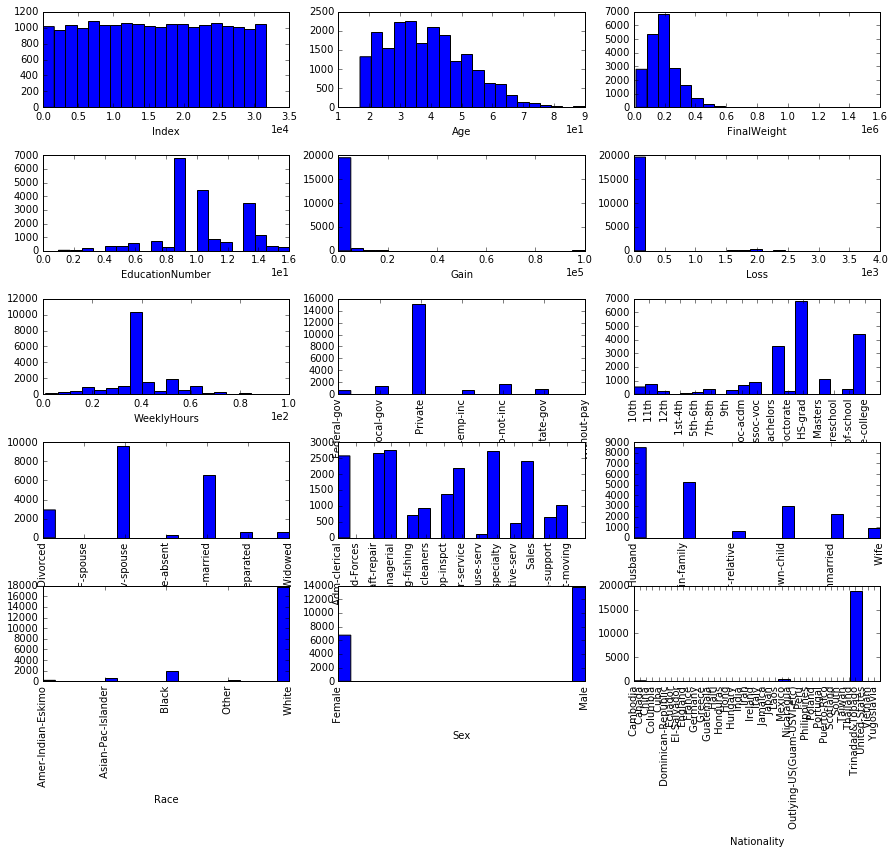

In [20]:
#Compute Correlations
num_features  = np.shape(data_train)[1]
correl = np.zeros((num_features, num_features))
for i in range(num_features):
    for j in range(i, num_features):
        correl[i][j] = np.corrcoef(data_train[:,i], data_train[:,j])[1,0]
        correl[j][i] = correl[i][j]
        if (correl[i,j]>=0.5 or correl[i,j]<=-0.5) and not(i==j):
            print("Correlation between {} and {} = {}".format(feature_name[i], feature_name[j], correl[i,j]))

#Create Histograms
plt.clf()
fig, axes = plt.subplots(5,3, figsize=(15,12))                                                                                                              
axes = axes.ravel()
j =0
fig.subplots_adjust(hspace=0.5)

for i in range(len(feature_name)):
    if not np.any(str_features==feature_name[i]):
            plt.sca(axes[j])
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            n, bins, patches = plt.hist(data_train[:,i],20,histtype='bar', stacked=False)
            plt.xlabel(feature_name[i])
            j = j+1
            
for i in range(len(feature_name)):
    if np.any(str_features==feature_name[i]):
            plt.sca(axes[j])
            n, bins, patches = plt.hist(data_train[:,i],20,histtype='bar', stacked=False)
            x = np.array(features[feature_name[i]].values())
            x_ticks = features[feature_name[i]].keys()
            locs, labels = plt.xticks(x,x_ticks)
            plt.setp(labels, rotation=90)
            plt.xlabel(feature_name[i])
            j = j+1


            
plt.show()
plt.close()
 


 # Hypothesis from Correlations and Histograms - 
 
Histograms - Age has a rough gaussian distribution with mean age of 38 and standard deviation of 13. The capital gains and losses are also very small for majority of population. However, there is a small group in both cases which have profitted and suffered economically to a huge extent. Most people had their education from high school to bachlors with few continuing education after that. Most of the employment are in private companies with an average 40hours a week. Most of these distribution are nearly gaussian. 

Correlations - From the correlations value, we see that none of the correlations (absolute value) exceeds 0.6 which shows that none of the features are strongly correlated. This hints that most of these features are independent and hence, we can expect that ICA would be a better approach in this case. On the other hand, since correlations are directly related with covariance, small correlations suggest that PCA may not be as successful. Let's show this by computing PCA - 


Best number of components by PCA CV = 14 and Cross Validation score = -66.8250810563 
Best number of components by PCA MLE = 14 and PCA score = -66.8085773067



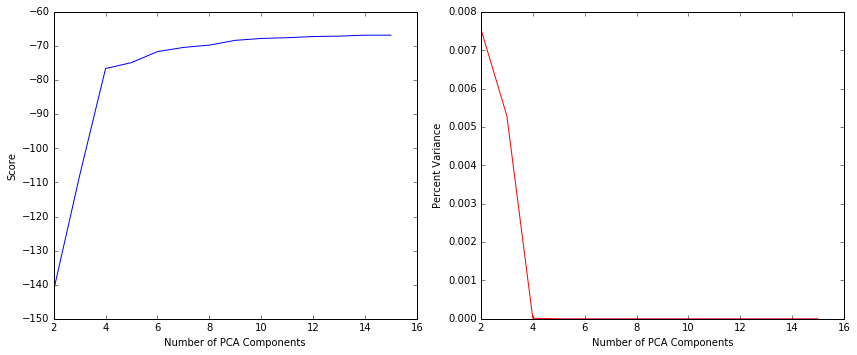

In [80]:
# Pricipal Component Analysis
PCA_Analysis (data_train)

# PCA Analysis :

As predicted earlier, PCA is clearly not a great way for dimensionality reduction as the score keeps improving as more features or components are added, as a results of which best score is achieved when dimensionlity matches the number of features. However, from the plot we see that the improvement in score is drastic from n = 0 to n = 4 and then increases very slowly. This is much clear in the plot of variance distribution which explains that most variance of the data is captured in first four components. This suggest that maximum information can be captured with just four PCA components. 

# Clustering

We now move towards Clustering. I follow the same path as Iris dataset. I first apply the clustering methods to this dataset and try to find the clusters in this dataset while comparing the clustering algorithms as well. Then, I perform dimensionality reduction using different methods followed by clustering and compare them by analyse the results. For Clustering, I mainly restrict to K-Means and Gaussian Mixtures while for component analysis, I use PCA, ICA and RCA methods. 



# K-Means:
K-Means is the most common clustering method and ideal for samples with small number of clusters and isotropic cluster distributions. It minimizes the inertia (sum of squares of within cluster distances) to compute the centres of clusters. However, in order to begin with k-Means, one needs to provide an optimal value of clusters which is  a common issue in using K-Means. There are several methods which can be used for this. Here I am going to restrict with two such methods:
1. Silhouette - Silhouette method measures the similarity of object to its own cluster in comparison with other cluster. Silhouette score ranges from -1 to 1 where negative values indicate the object has been assigned to incorrect cluster while increasing positive value shows better chances that objects have been assigned to right clusters. We can use Silhoutte score to find the optimal values of clusters. 

I vary the number of clusters from 2 to 17 and find that Silhouette score is best for n=2, 5 and 8. However, for n=2, the size of one cluster is quite large then other which suggests grouping of clusters. The clusters are almost similar sizes for n=5 and n=8. 

2. Elbow Method - Elbow method in general looks at percentage variance exlained by clusters as function of number of clusters. Inertia is a measure of this variance and thus can be used to compute the number of clusters. From the plots (in next section) we see that inertia decreases drastically till n~7 and then slows down approaching constancy for large number of clusters. 

3. Score and Timing - Comparing the plots of scores and timing, the n~7 again turns out to be a good value for number of clusters. More specifically, the score starts growing constant after n~7 while time taken for fitting data to these number of clusters is also not huge (0.4 seconds). 

Silhouette score for n = 2 clusters is 0.579097294766
Silhouette score for n = 5 clusters is 0.483112058605
Silhouette score for n = 8 clusters is 0.501826269767
Silhouette score for n = 11 clusters is 0.396245786528
Silhouette score for n = 14 clusters is 0.397346440734
Silhouette score for n = 17 clusters is 0.383101671047


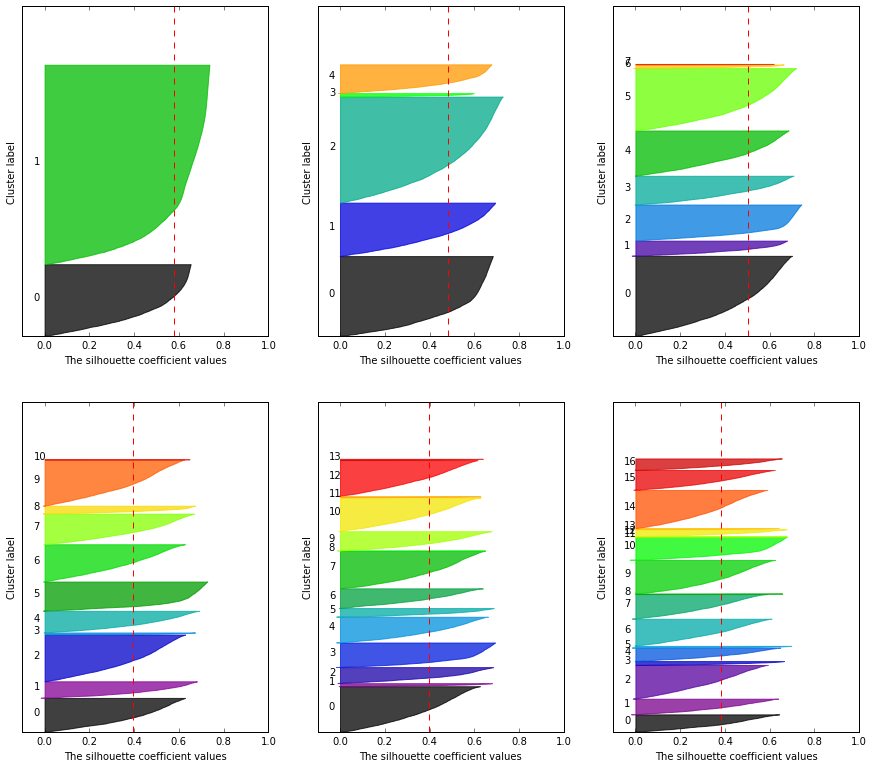

In [27]:
Silhouette_plots( data_train)

Method 	 Time 	 Inertia 	 Homo 	 Compl 	 v-meas 	 ARI 	 AMI 	 Silhoutte
k_means_13 	 1.177 	 6545824614497 	 0.001 	 0.000 	 0.000 	 -0.001 	 0.000 	 0.375   
k_means_3 	 0.162 	 51159933339867 	 0.000 	 0.000 	 0.000 	 -0.000 	 0.000 	 0.522   
k_means_5 	 0.411 	 25616931229505 	 0.001 	 0.000 	 0.000 	 -0.002 	 0.000 	 0.501   
k_means_7 	 0.413 	 14755080595353 	 0.001 	 0.000 	 0.001 	 -0.002 	 0.000 	 0.495   
k_means_8 	 0.496 	 12126391399666 	 0.001 	 0.000 	 0.000 	 -0.002 	 0.000 	 0.513   
k_means_9 	 0.686 	 10098372334873 	 0.001 	 0.000 	 0.000 	 -0.001 	 0.000 	 0.441   


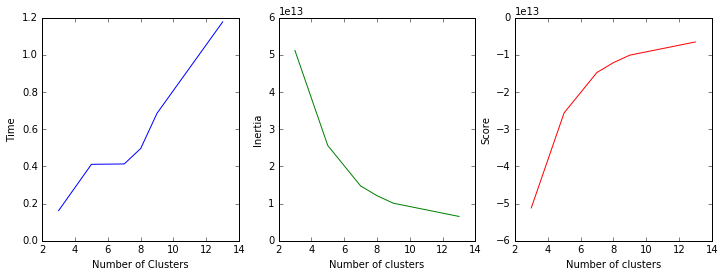

In [29]:
kmeans_dict = {'k_means_3': KMeans(n_clusters=3, random_state=10),'k_means_5': KMeans(n_clusters=5, random_state=10), 'k_means_8': KMeans(n_clusters=8, random_state=12),
              'k_means_7': KMeans(n_clusters=7, random_state=10), 'k_means_9':KMeans(n_clusters=9, random_state=10),
                'k_means_9': KMeans(n_clusters=9, random_state=10), 'k_means_13':KMeans(n_clusters=13, random_state=10)}



time_dict_km, inertia_dict_km, score_dict_km, key_km = Analyse_kmeans(data_train, np.squeeze(y_train), k_means_dict=kmeans_dict)
k_arr, time_km, inertia_km, score_km  = [],[],[],[]
key_dict = {}
for key in key_km:
    val = int(str.split(key,'_')[-1])
    k_arr.append(val)
    key_dict[val] = key
    
k_arr = sorted(k_arr)

for k in k_arr:
    key = key_dict[k]
    time_km.append(time_dict_km[key])
    inertia_km.append(inertia_dict_km[key])
    score_km.append(score_dict_km[key])
  
    

# Inertia - Sum of distances of samples to their closest cluster center.
plt.clf()
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
ax1.plot(k_arr, time_km, c='b')
ax2.plot(k_arr, inertia_km, c='g')
ax3.plot(k_arr, score_km, c='r')
ax1.set_xlabel('Number of Clusters')
ax2.set_xlabel('Number of clusters')
ax3.set_xlabel('Number of clusters')
ax1.set_ylabel('Time')
ax2.set_ylabel('Inertia')
ax3.set_ylabel('Score')
plt.show()
plt.close()





# Gaussian Mixture - 

Gaussian mixture models are more complicated versions of K-Means with ability to provide more information about the cluster distribution such as the covariance structure of the data. They are more suited for clusters of varying shapes and sizes in comparison with K-Means. They assume that the data is generated from a mixture of mutlivariate gaussian distributions with unknown parameters and use expectation-maximization methods to identify the right labels of each object. 

To find the number of  number of components for this model, we can again use BIC criterion maximum log-likelihood:
1. BIC criterion - Bayesian Information Criterion is a common method used to to determine the number of components. Number of components with smallest BIC values are preferred. From the plots, we find that n = 7 is the most optimal value which is consistent with K-Means. 
2. We can also look at the  score (maximum log-likelihood) of Gaussian Mixture model which again maximizes at n = 7. 

The concerns for GMM models arises from the Silhouette plots which shows negative score for almost all tested number of components. As mentioned before, negative Silhouette score suggests incorrect association of sample points with clusters. Hence, we now try to use dimensionality reduction methods to overcome this issue. 

Method 	 Time 	 Homo 	 Compl 	 v-meas 	 ARI 	 AMI 	 Silhoutte
GM(n_comp=11) 	  1 	 0.088 	 0.043 	 0.058 	 0.072 	 0.043 	 -0.156   
GM(n_comp=13) 	  1 	 0.088 	 0.043 	 0.058 	 0.062 	 0.043 	 -0.633   
GM(n_comp=8) 	  0 	 0.081 	 0.042 	 0.055 	 0.072 	 0.042 	 -0.131   
GM(n_comp=3) 	  0 	 0.054 	 0.039 	 0.045 	 0.004 	 0.039 	 -0.039   
GM(n_comp=2) 	  0 	 0.009 	 0.010 	 0.010 	 -0.040 	 0.009 	 0.062   
GM(n_comp=7) 	  0 	 0.081 	 0.032 	 0.046 	 0.047 	 0.032 	 -0.381   
GM(n_comp=6) 	  0 	 0.074 	 0.039 	 0.051 	 0.073 	 0.039 	 -0.210   
GM(n_comp=4) 	  0 	 0.069 	 0.075 	 0.072 	 0.187 	 0.069 	 -0.080   
GM(n_comp=10) 	  0 	 0.084 	 0.042 	 0.056 	 0.063 	 0.042 	 -0.348   
GM(n_comp=14) 	  1 	 0.159 	 0.059 	 0.086 	 0.092 	 0.059 	 -0.425   
GM(n_comp=5) 	  0 	 0.067 	 0.050 	 0.057 	 0.131 	 0.050 	 -0.144   
GM(n_comp=12) 	  0 	 0.078 	 0.031 	 0.044 	 0.044 	 0.031 	 -0.363   
GM(n_comp=9) 	  0 	 0.130 	 0.057 	 0.079 	 0.070 	 0.057 	 -0.557   


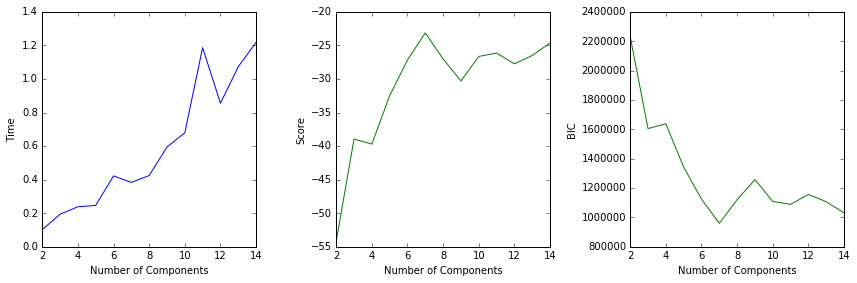

In [43]:
gm_dict = {}
n_comp = np.arange(2,15,1)
for n in n_comp:
    key = 'GM(n_comp=%i)'%n
    gm_dict[key] = GM(n_components=n, covariance_type = 'full', random_state=10)


time_dict_gm, score_dict_gm, bic_dict_gm, key_gm = Analyse_EM(data_train,y_train, gm_dict=gm_dict)

k_arr, time_gm, score_gm, bic_gm  = [],[],[], []
key_dict = {}
for key in key_gm:
    val = str.split(key,'=')[-1]
    val = int(str.split(val,')')[0])
    k_arr.append(val)
    key_dict[val] = key
    
k_arr = sorted(k_arr)

for k in k_arr:
    key = key_dict[k]
    time_gm.append(time_dict_gm[key])
    score_gm.append(score_dict_gm[key])
    bic_gm.append(bic_dict_gm[key])

#print("Time taken in gaussian mixtures = {}".format(time_gm))
#print("Score in gaussian mixtures = {}".format(score_gm))
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
ax1.plot(n_comp, time_gm, c='b')
ax2.plot(n_comp, score_gm, c='g')
ax3.plot(n_comp, bic_gm, c='g')

ax1.set_xlabel('Number of Components')
ax2.set_xlabel('Number of Components')
ax3.set_xlabel('Number of Components')

ax1.set_ylabel('Time')
ax2.set_ylabel('Score')
ax3.set_ylabel('BIC')
plt.tight_layout()
plt.show()
plt.close()


Silhouette score for n = 2 clusters/components is 0.0940177114043
Silhouette score for n = 5 clusters/components is -0.0516263388108
Silhouette score for n = 8 clusters/components is -0.30221663552
Silhouette score for n = 11 clusters/components is -0.366927245291
Silhouette score for n = 14 clusters/components is -0.503237877417
Silhouette score for n = 17 clusters/components is -0.393262875749


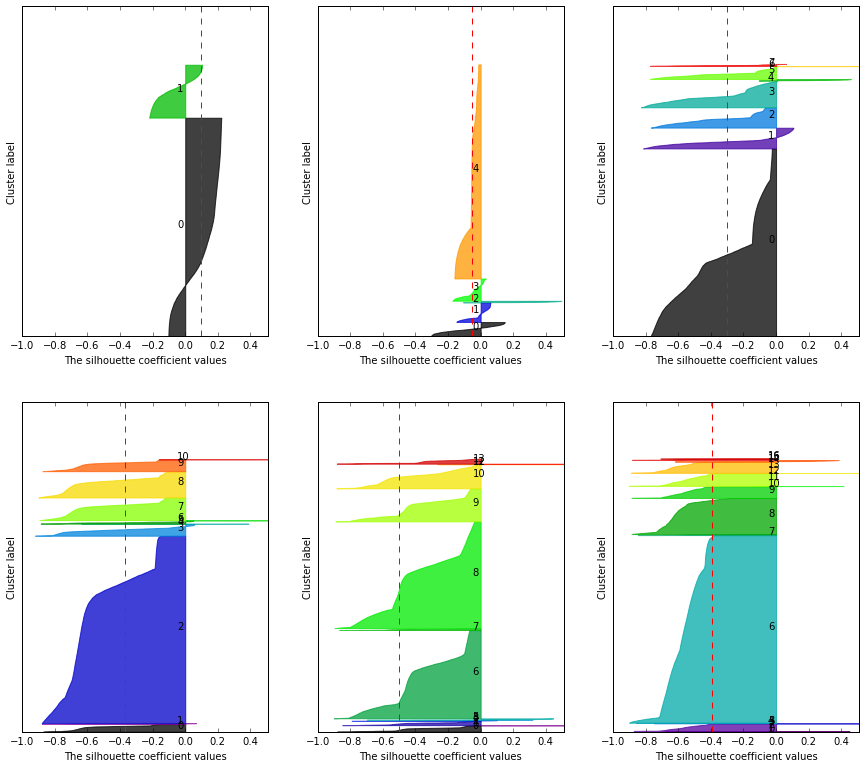

In [32]:
Silhouette_plots( data_train, clf_name="EM")

# Component Analysis

# Principal Component Analysis:

PCA tries to reduce the dimensionality of data by looking for new axes which has maximum variance information. Mathematically these new components translates to eigenvectors of the covariance matrix and the variation information is given by the eigen-values of this matrix. Earlier we found that n=4 should be a good value for optimal number of components to capture the variance content of the data. Let us now test it independently by varying number of components and use K-Means and Gaussian Methods to find the optimal value. Following the previous analysis, here I choose the number of clusters as 7. 

I first perform a dimensionality reduction of the data followed with training data separately with K-Means and Gaussian Mixture model and compute the Silhouette score. This is repeated for varying number of PCA components from 2 to 12.

Results: As predicted, we find that PCA does not perform very well here. The Silhouette score for K-means fluctuates between 0.45 and 0.5 with a small maxima for n=4. The effect on Gaussian-Mixture is no better. The score still remains negative for n>=3 with huge variation from 0.4 to -0.5. 

In [50]:
n_samples, n_features = np.shape(data_train)[:]
n_comp = np.arange(2,12, 1)


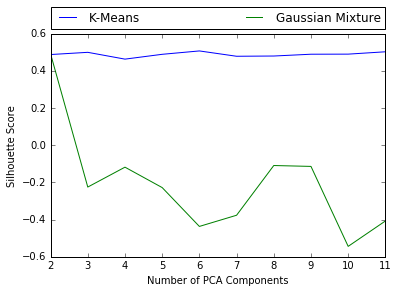

In [49]:
silh_score_kmpca, silh_score_empca, time_km, time_gm = [], [], [], []
for n in n_comp:
    data_pca, time_pca = func_PCA(n, data_train)
    data_copy = np.copy(data_pca)
    time_start = time.time()
    clf = KMeans(n_clusters=7, random_state=10)
    clstr_labels = clf.fit_predict(data_copy)
    avg_silh_score = metrics.silhouette_score(data_copy, clstr_labels,metric='euclidean', sample_size=500)
    silh_score_kmpca.append(avg_silh_score)
    #  print("Kmeans: Silhouette score for n = {} clusters is {}".format(n, avg_silh_score))
    time_km.append(time.time() - time_start)
    del data_copy
    
    time_start = time.time()
    data_copy = np.copy(data_pca)
    clf = GM(n_components=7, covariance_type = 'full', random_state=10)
    clf.fit(data_copy)
    clstr_labels = clf.predict(data_copy)
    avg_silh_score = metrics.silhouette_score(data_copy, clstr_labels,metric='euclidean', sample_size=500)
    silh_score_empca.append(avg_silh_score)
    # print("EM: Silhouette score for n = {} clusters is {}".format(n, avg_silh_score))
    time_gm.append(time.time() - time_start)
    del data_copy
    
   
plt.plot(n_comp, silh_score_kmpca, color='b',label = 'K-Means')
plt.plot(n_comp, silh_score_empca, color='g',label = 'Gaussian Mixture')
plt.xlabel('Number of PCA Components')
plt.ylabel('Silhouette Score')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()
plt.close()
    #Score
    #Silhoutte Plot
    #print("Time for PCA = %f, Time for K-Means = %f, Total Time = %f"%(time_pca, time_km, time_pca+time_km))
    #print("Score by PCA+Kmeans = ", score_pca)

# ICA:
As shown earlier, the correlations between various components are extremely small which suggest that the attributes are mutually independent. This is a perfect case for the ICA which can reduce the dimensionality by capturing the mutual information between various features. Here I repeat the same analysis as before, except the dimensionality reduction is performed using ICA. As can be seen in the plot, there is a drastic change in the Silhouette score. While for K-Means the Silhoutte score reduces with peak score at n=4, the is a contrasting change in Gaussian Mixture models with all scores turning miraculously positive, again with a peak at n=4. 

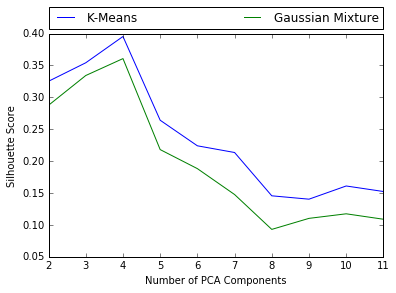

In [51]:
silh_score_kmica, silh_score_emica, time_km, time_gm = [], [], [], []
for n in n_comp:
    data_ica, time_ica = func_ICA(n, data_train)
    data_copy = np.copy(data_ica)
    time_start = time.time()
    clf = KMeans(n_clusters=5, random_state=10)
    clstr_labels = clf.fit_predict(data_copy)
    avg_silh_score = metrics.silhouette_score(data_copy, clstr_labels,metric='euclidean', sample_size=500)
    silh_score_kmica.append(avg_silh_score)
    #  print("Kmeans: Silhouette score for n = {} clusters is {}".format(n, avg_silh_score))
    time_km.append(time.time() - time_start)
    del data_copy
    
    time_start = time.time()
    data_copy = np.copy(data_ica)
    clf = GM(n_components=5, covariance_type = 'full', random_state=10)
    clf.fit(data_copy)
    clstr_labels = clf.predict(data_copy)
    avg_silh_score = metrics.silhouette_score(data_copy, clstr_labels,metric='euclidean', sample_size=500)
    silh_score_emica.append(avg_silh_score)
    #  print("EM: Silhouette score for n = {} clusters is {}".format(n, avg_silh_score))
    time_gm.append(time.time() - time_start)
    del data_copy
   
plt.plot(n_comp, silh_score_kmica, color='b',label = 'K-Means')
plt.plot(n_comp, silh_score_emica, color='g',label = 'Gaussian Mixture')
plt.xlabel('Number of PCA Components')
plt.ylabel('Silhouette Score')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()
plt.close()

# RCA:
RCA is a more moderate method which does not rely on one single feature like mutual information or covariance. It rather incorporates a part of all this by capturing some information from almost all the features. The components of RCA can be thought of as linear combination of original attributes and thus different RCA component carry some part of each feature depending of its contribution. As a result, while it may not yield exemplary results, however, it presents a more robust strategy. This can be seen from the plot below. 

The results are consistent with previous observations. The Silhouette scores maximizes for n=4 for both K-Means and Gaussian Mixture model. It should be noted that these results are highly dependent on the randomization (which is fixed by parameter rs here). Its also interesting to see that for particular state of randomization, both K-Means and Gaussian Mixture performs even better then ICA. 

EM: Silhouette score for n = 2 clusters is 0.943039313135
EM: Silhouette score for n = 3 clusters is 0.937003407542
EM: Silhouette score for n = 4 clusters is 0.948974604316
EM: Silhouette score for n = 5 clusters is 0.497139937499
EM: Silhouette score for n = 6 clusters is 0.173986043898
EM: Silhouette score for n = 7 clusters is -0.00113883074448
EM: Silhouette score for n = 8 clusters is -0.0669658552057
EM: Silhouette score for n = 9 clusters is -0.0684579196921
EM: Silhouette score for n = 10 clusters is -0.0620319287077
EM: Silhouette score for n = 11 clusters is -0.21746532118


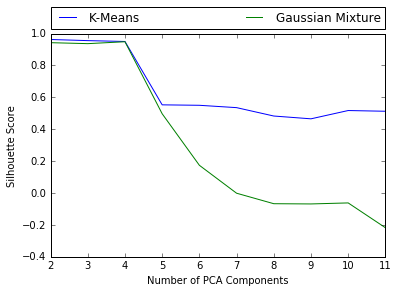

In [70]:
silh_score_kmrca, silh_score_emrca, time_km, time_gm = [], [], [], []
for n in n_comp:
    data_rca, time_rca = func_RCA(n, data_train, rs=7)   #rs = randomization_seed
    data_copy = np.copy(data_rca)
    time_start = time.time()
    clf = KMeans(n_clusters=5, random_state=10)
    clstr_labels = clf.fit_predict(data_copy)
    avg_silh_score = metrics.silhouette_score(data_copy, clstr_labels,metric='euclidean', sample_size=500)
    silh_score_kmrca.append(avg_silh_score)
    #print("Kmeans: Silhouette score for n = {} clusters is {}".format(n, avg_silh_score))
    time_km.append(time.time() - time_start)
    del data_copy
    
    time_start = time.time()
    data_copy = np.copy(data_rca)
    clf = GM(n_components=5, covariance_type = 'full', random_state=10)
    clf.fit(data_copy)
    clstr_labels = clf.predict(data_copy)
    avg_silh_score = metrics.silhouette_score(data_copy, clstr_labels,metric='euclidean', sample_size=500)
    silh_score_emrca.append(avg_silh_score)
    print("EM: Silhouette score for n = {} clusters is {}".format(n, avg_silh_score))
    time_gm.append(time.time() - time_start)
    del data_copy
   
plt.plot(n_comp, silh_score_kmrca, color='b',label = 'K-Means')
plt.plot(n_comp, silh_score_emrca, color='g',label = 'Gaussian Mixture')
plt.xlabel('Number of PCA Components')
plt.ylabel('Silhouette Score')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()
plt.close()